In [1]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
import torch
# Check if MPS (Apple Silicon GPU) is available
print(torch.backends.mps.is_available())
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f"Using device: {device}")

True
Using device: mps


In [3]:
# 1. Prétraitement des données
def get_transform(channels):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * channels, (0.5,) * channels)  # Normalize based on number of channels
    ])

In [4]:
def load_dataset(dataset_name, train=True, batch_size=64, shuffle=True, root='./data'):
    if dataset_name == 'MNIST':
        channels = 1
        dataset = datasets.MNIST(root=root, train=train, download=True, transform=get_transform(channels))
    elif dataset_name == 'CIFAR10':
        channels = 3
        dataset = datasets.CIFAR10(root=root, train=train, download=True, transform=get_transform(channels))
    elif dataset_name == 'FashionMNIST':
        channels = 1
        dataset = datasets.FashionMNIST(root=root, train=train, download=True, transform=get_transform(channels))
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader, channels

In [5]:
train_dataset_name = 'MNIST'
eval_dataset_name = 'FashionMNIST'

train_loader, train_channels = load_dataset(train_dataset_name, train=True, batch_size=64, shuffle=True)
eval_loader, eval_channels = load_dataset(eval_dataset_name, train=False, batch_size=64, shuffle=False)

In [6]:
# 2. Définition du modèle Autoencodeur
class Autoencoder(nn.Module):
    def __init__(self, in_channels=1):  # Default to 1 channel (MNIST), but can be overridden
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),  # Input: [in_channels, H, W] -> [32, H/2, W/2]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [32, H/2, W/2] -> [64, H/4, W/4]
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64, H/4, W/4] -> [32, H/2, W/2]
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # [32, H/2, W/2] -> [in_channels, H, W]
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# 3. Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = Autoencoder(in_channels=train_channels) # MNIST
model.to(device)
criterion = nn.MSELoss()  # Erreur quadratique moyenne pour la reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# 4. Entraînement du modèle
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}")

Epoch [1/5], Train Loss: 0.8989
Epoch [2/5], Train Loss: 0.8798
Epoch [3/5], Train Loss: 0.8797
Epoch [4/5], Train Loss: 0.8796
Epoch [5/5], Train Loss: 0.8796


In [9]:
model.eval()
eval_loss = 0
with torch.no_grad():
    for data in eval_loader:
        img, _ = data
        if img.shape[2:] != (28, 28):  # Resize if necessary
            img = transforms.functional.resize(img, (28, 28))
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)
        eval_loss += loss.item()

print(f"Evaluation Loss on {eval_dataset_name}: {eval_loss/len(eval_loader):.4f}")

Evaluation Loss on FashionMNIST: 0.6263


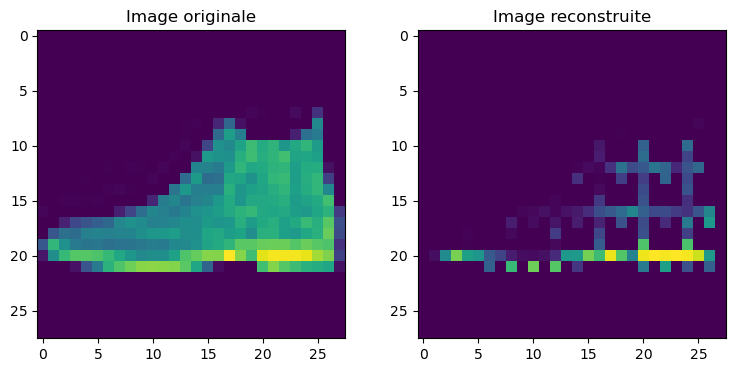

In [12]:
# 5. Visualisation d'une image reconstruite
data_iter = iter(eval_loader)
images, _ = next(data_iter)
images = images.to(device)

reconstructed = model(images)

# Affichage de l'image originale et reconstruite
original_image = images[0].permute(1, 2, 0).cpu().numpy()
reconstructed_image = reconstructed[0].detach().cpu().permute(1, 2, 0).numpy()

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Image originale")
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title("Image reconstruite")
plt.show()

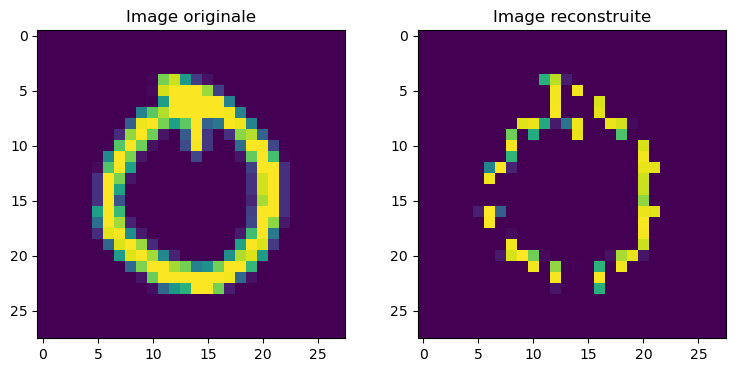

In [13]:
# 5. Visualisation d'une image reconstruite
data_iter = iter(train_loader)
images, _ = next(data_iter)
images = images.to(device)

reconstructed = model(images)

# Affichage de l'image originale et reconstruite
original_image = images[0].permute(1, 2, 0).cpu().numpy()
reconstructed_image = reconstructed[0].detach().cpu().permute(1, 2, 0).numpy()

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Image originale")
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title("Image reconstruite")
plt.show()